In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix


In [2]:
df = pd.read_csv("loan_data.csv")
df.head()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268114 entries, 0 to 268113
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    268114 non-null  int64  
 1   annual_income         268114 non-null  float64
 2   debt_to_income_ratio  268114 non-null  float64
 3   credit_score          268114 non-null  int64  
 4   loan_amount           268114 non-null  float64
 5   interest_rate         268114 non-null  float64
 6   gender                268114 non-null  object 
 7   marital_status        268114 non-null  object 
 8   education_level       268114 non-null  object 
 9   employment_status     268114 non-null  object 
 10  loan_purpose          268114 non-null  object 
 11  grade_subgrade        268114 non-null  object 
 12  loan_paid_back        268114 non-null  int64  
dtypes: float64(4), int64(3), object(6)
memory usage: 26.6+ MB


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back
count,268114.000000,268114.000000,268114.000000,268114.000000,268114.000000,268114.000000,268114.000000
mean,134056.500000,48203.659176,0.120764,680.831732,15028.884002,12.357615,0.798422
std,77397.989374,26735.817913,0.068750,55.404553,6932.802588,2.008781,0.401180
min,0.000000,6002.430000,0.011000,395.000000,500.910000,3.660000,0.000000
25%,67028.250000,27897.190000,0.072000,646.000000,10281.410000,10.990000,1.000000
50%,134056.500000,46552.490000,0.096000,682.000000,15011.150000,12.370000,1.000000
75%,201084.750000,60981.320000,0.156000,719.000000,18872.210000,13.680000,1.000000
max,268113.000000,393381.740000,0.577000,849.000000,48959.950000,20.840000,1.000000


In [3]:
df['loan_paid_back'].value_counts(normalize=True)


,proportion
loan_paid_back,
1,0.798422
0,0.201578


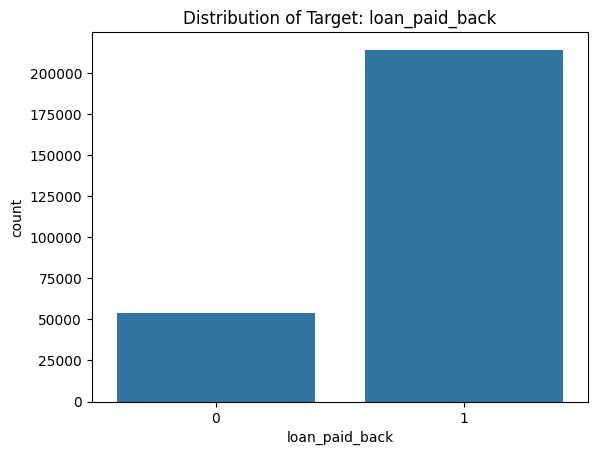

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='loan_paid_back', data=df)
plt.title("Distribution of Target: loan_paid_back")
plt.show()


In [13]:
numeric_features = [
    'annual_income',
    'debt_to_income_ratio',
    'credit_score',
    'loan_amount',
    'interest_rate'
]

categorical_features = [
    'gender',
    'marital_status',
    'education_level',
    'employment_status',
    'loan_purpose',
    'grade_subgrade'      # ← updated (single column)
]



In [19]:
target = "loan_paid_back"
id_col = "id"

X = df.drop(columns=[target, id_col])
y = df[target]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [20]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


In [21]:
from sklearn.preprocessing import OneHotEncoder

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])


In [22]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

log_reg = LogisticRegression(
    max_iter=500,
    class_weight="balanced"
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", log_reg)
])


In [24]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10],
    "classifier__penalty": ["l2"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['annual_income',
                                                                          'debt_to_income_ratio',
                                                                          'credit_score',
                                                                          'loan_amount',
                                                                          'interest_rate']),
                                                                        ('cat',
                                                                         Pipeline(st...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['gender',
                                                                          'marital_status',
                                                                          'education_level',
                                                                          'employment_status',
                                                                          'loan_purpose',
                                                                          'grade_subgrade'])])),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=500))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10],
                         'classifier__penalty': ['l2']},
             scoring='roc_auc', verbose=1)

In [25]:
print("Best CV AUC:", grid_search.best_score_)
print("Best Params:", grid_search.best_params_)

best_model = grid_search.best_estimator_


Best CV AUC: 0.9094761457314761
Best Params: {'classifier__C': 1, 'classifier__penalty': 'l2'}


In [26]:
y_proba_test = best_model.predict_proba(X_test)[:, 1]


In [27]:
from sklearn.metrics import roc_auc_score

test_auc = roc_auc_score(y_test, y_proba_test)
print("Test ROC-AUC:", test_auc)


Test ROC-AUC: 0.9122130105622512


In [28]:
from sklearn.metrics import roc_curve
import numpy as np

fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
youden_j = tpr - fpr
best_threshold = thresholds[np.argmax(youden_j)]

print("Optimal Threshold:", best_threshold)


Optimal Threshold: 0.5008685645617152


In [29]:
y_pred_test = (y_proba_test >= best_threshold).astype(int)


In [31]:
X_test_with_meta = X_test.copy()
X_test_with_meta['loan_paid_back'] = y_test.values
X_test_with_meta['y_proba'] = y_proba_test


In [32]:
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

education_levels = X_test_with_meta['education_level'].unique()

edu_auc = {}

for level in education_levels:
    subset = X_test_with_meta[X_test_with_meta['education_level'] == level]

    y_true_sub = subset['loan_paid_back']
    y_proba_sub = subset['y_proba']

    # AUC cannot be computed if only one class is present
    if len(np.unique(y_true_sub)) < 2:
        print(f"Skipping '{level}' because it has only one class.")
        continue

    auc_value = roc_auc_score(y_true_sub, y_proba_sub)
    edu_auc[level] = auc_value

edu_auc_df = pd.DataFrame.from_dict(edu_auc, orient='index', columns=['AUC'])
edu_auc_df = edu_auc_df.sort_values('AUC', ascending=False)

edu_auc_df


,AUC
Other,0.925192
Bachelor's,0.912819
High School,0.910770
PhD,0.908945
Master's,0.908916


In [33]:
loan_purposes = X_test_with_meta['loan_purpose'].unique()

purpose_auc = {}

for purpose in loan_purposes:
    subset = X_test_with_meta[X_test_with_meta['loan_purpose'] == purpose]

    y_true_sub = subset['loan_paid_back']
    y_proba_sub = subset['y_proba']

    if len(np.unique(y_true_sub)) < 2:
        print(f"Skipping '{purpose}' because it has only one class.")
        continue

    auc_value = roc_auc_score(y_true_sub, y_proba_sub)
    purpose_auc[purpose] = auc_value

purpose_auc_df = pd.DataFrame.from_dict(purpose_auc, orient='index', columns=['AUC'])
purpose_auc_df = purpose_auc_df.sort_values('AUC', ascending=False)

purpose_auc_df


,AUC
Education,0.923703
Vacation,0.920240
Medical,0.919069
Home,0.914401
Other,0.912166
Business,0.912048
Debt consolidation,0.911647
Car,0.901277


In [35]:
top_3 = purpose_auc_df.head(3)
top_3


,AUC
Education,0.923703
Vacation,0.920240
Medical,0.919069


In [36]:
bottom_3 = purpose_auc_df.tail(3)
bottom_3


,AUC
Business,0.912048
Debt consolidation,0.911647
Car,0.901277


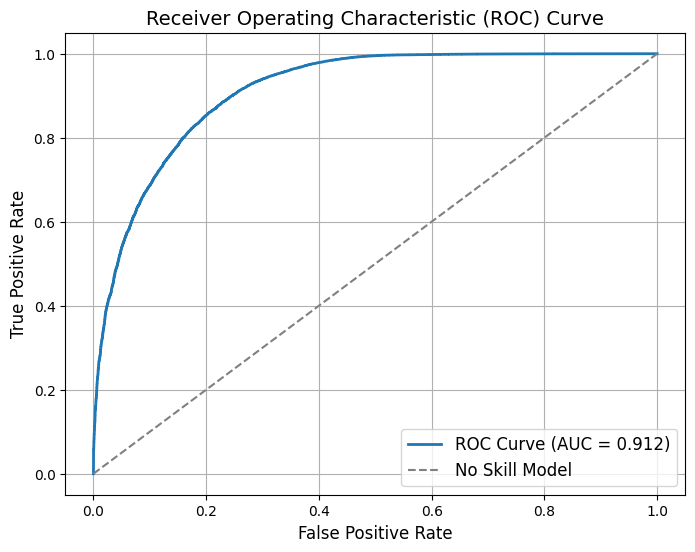

In [37]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='No Skill Model')

plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()
